# Requirements

In [2]:
# import various distribution shapes
from scipy.stats import trapz
from scipy.stats import norm
from scipy.stats import halfnorm

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import sddk

In [3]:
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


# Modelling ranges


As a minimal example, let's assume that we have a date like "4th c. BC".
As a first step, we have to translate this into an interval, i.e. to operationalize its start and end points:

In [4]:
start = -400
stop = -301

 Further,  I assume that the the probability that the object emerged in 385 BC, 350 BC or 320 BC is **approximately equal** . 
At the same time, it is **less likely** that the  object emerged in the first or last decade of the century, since this would be probably coded in another way (e.g. "beginning of the 4th c. BC" etc.).

It seems that the best way how to model this is through a [trapezoidal distrubution](https://en.wikipedia.org/wiki/Trapezoidal_distribution).

In Python, trapezoidal distribution is implemented in SciPy library as [scipy.stats.trapz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.trapz.html). 



## Uniform distribution & Trapezoidal distribution


We will use this function as a core for our function optimized for working with date ranges

In [5]:
def dist_range(start, stop, size=1, b=0): # this function has been already implemented into modelling_distributions.py
    """
    get random numbers of size = size on the basis of a start date and an end date
    by default: uniform distribution
    by specifying b parameter you get a trapezoidal distribution defined by the first turning point (lower bound)
    """
    r = trapz.rvs(b, 1-b, size=size)
    duration = abs((start)-stop)
    if duration == 0:
        random_values = [start] * size
        return random_values
    else:
        random_values = list(((r * duration) + start).round().astype(int))
    if size == 1: # if only one number, return it as a number
        return random_values[0]
    else: # otherwise return a list of values
        return random_values

In [6]:
start = -20
stop = -18
print(dist_range(start, stop, 30))

[-18, -20, -19, -18, -18, -18, -20, -19, -19, -19, -19, -18, -19, -18, -20, -18, -19, -20, -20, -19, -18, -18, -19, -19, -18, -18, -19, -18, -20, -19]


If we specify only start and end, it returns only one random number within the range. By default, the two bending points are configured to 0.1 and 0.9  of the duration of the function.

In [7]:
dist_range(start, stop)

-19

This way we can produce a large amount of numbers for each date range in our dataset

In [8]:
raw_date = "4th c. BC"
start = -400
stop = -301
n_of_iterations = 100000
iters = dist_range(start, stop, n_of_iterations)

For one date range, the resulting distrubution might be visualized by means of a histogram:

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-400.0, -301.0)

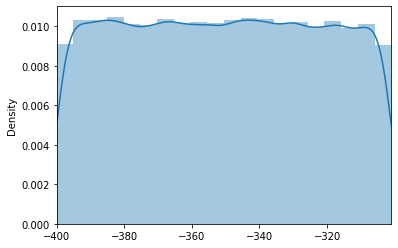

In [9]:
sns.distplot(iters, bins=20)
plt.xlim(start, stop)

# Modelling ante quem & post quem

A very common way of dating in our dataset is using **ante quem** (before that date) and **post quem** (after that date).

Again, here we have to ask about the shape of the distribution we want to model.

Here we employ halfnormal distribution.

Here we can especially play with the `scale` parameter.



/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


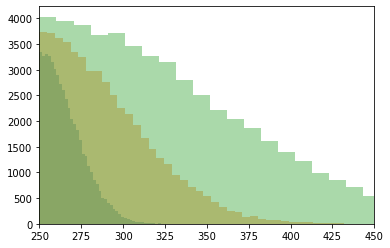

In [10]:
for scale in [20, 50, 100]:
  r = halfnorm.rvs(250, scale, 50000)
  sns.distplot(r, kde=False)
  plt.xlim(250, 450)

`scale`=50 appears to be very useful for applications where centuries are common, like PHI or EDH. So let's implement it to our model as default value.

In [11]:
def dist_ante_post(date, date_type, size=1, scale=50): # this function has been already implemented into modelling_distributions.py
    """
    get random numbers of size size ib on the basis of start date and end date and trapezoid distribution defined by first turn point (lower bound)
    """
    if "post" in date_type:
        r = halfnorm.rvs(date, scale, size)
        random_values = list(r.astype(int))
    if "ante" in date_type:
        r = halfnorm.rvs(scale=scale, size=size)
        random_values =  list((date - r).astype(int))
    if 0 in random_values:
        random_values_without_0 = []
        for value in random_values:
            if value < 0:
                random_values_without_0.append(value)
            else:
                random_values_without_0.append(value + 1)
        random_values = random_values_without_0
    if size == 1:
        return random_values[0]
    else:
        return random_values

In [12]:
# simple test with "post"
dist_ante_post(250, "post", size=10, scale=5)

[254, 251, 257, 251, 252, 252, 251, 255, 253, 252]

In [13]:
# simple test with "ante"
dist_ante_post(250, "ante", 10, 50)

[223, 189, 229, 238, 115, 215, 230, 148, 218, 230]

What exactly does the scale parameter?

# function "model_date()"

In [14]:
def model_date(start, stop, size=1, scale=25, b=0):
    """
    combine dist_range() and dist_ante_post()
    """
    try:
        randoms = dist_range(int(start), int(stop), size=size, b=b)
    except:
        try:
            randoms =  dist_ante_post(int(start), "post", size=size, scale=scale)
        except:
            try:
                randoms =  dist_ante_post(int(stop), "ante", size=size, scale=scale)
            except:
                randoms = None
    return randoms


In [15]:
# example: 
# both dates valid
start = -400
stop = -390
print(model_date(start, stop, size=20, b=0))

[-394, -398, -395, -399, -399, -394, -395, -394, -391, -399, -396, -395, -392, -398, -400, -398, -396, -398, -399, -399]


In [16]:
# example: 
# both dates valid
# modified bounding_box_b to uniform distr
start = -400
stop = None
print(model_date(start, stop, size=20))

[-331, -372, -392, -372, -369, -383, -399, -370, -392, -384, -350, -389, -396, -393, -385, -398, -366, -396, -374, -357]


In [17]:
# example: 
# invalid start interpreted as ante stop
start = "something nonnumerical"
stop = 72
model = model_date(start, stop, size=1000)

# Distribution shapes overview

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, '(d) Half-normal distribution')

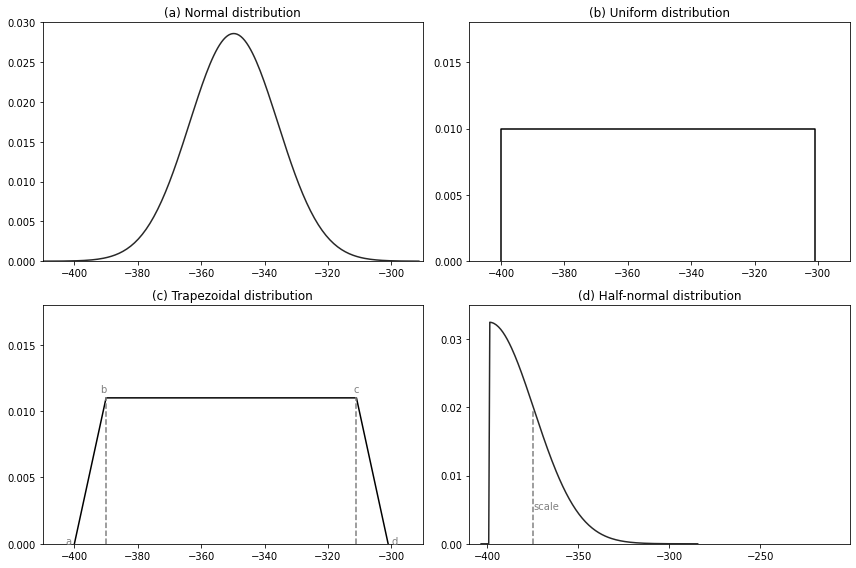

In [18]:
fig, [[ax0, ax1], [ax2, ax3]] = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)

# NORMAL DISTRIBUTION
r = norm.rvs(-350, 14, 10000)
sns.distplot(r, fit=norm, hist=False, kde=False, ax=ax0)
ax0.set_xlim(-410, -290)
ax0.set_ylim(0, 0.03)
ax0.set_title("(a) Normal distribution")


# UNIFORM DISTRIBUTION
ax1.plot([-400, -400, -301, -301], [0, 0.01, 0.01, 0], color="black")
ax1.set_xlim(-410, -290)
ax1.set_ylim(0, 0.018)
ax1.set_yticks([0, 0.005, 0.01, 0.015])
ax1.set_title("(b) Uniform distribution")

# TRAPEZOIDAL DISTRIBUTION
ax2.plot([-400, -390, -311, -301], [0, 0.011, 0.011, 0], color="black")
ax2.set_xlim(-410, -290)
ax2.set_ylim(0, 0.018)
ax2.set_yticks([0, 0.005, 0.01, 0.015])
ax2.axvline(-390, 0, 0.615,linestyle="--", color="grey")
ax2.axvline(-311, 0, 0.615,linestyle="--", color="grey")
ax2.text(-403, 0, "a", color="grey") 
ax2.text(-392, 0.0114, "b", color="grey") 
ax2.text(-312, 0.0114, "c", color="grey") 
ax2.text(-300, 0, "d", color="grey") 


ax2.set_title("(c) Trapezoidal distribution")

# HALFNORMAL DISTRIBUTION
r = model_date(-400, "", 100000)
sns.distplot(r, fit=halfnorm, hist=False, kde=False, ax=ax3)
ax3.set_xlim(-410, -201)
ax3.set_ylim(0, 0.035)
ax3.set_yticks([0, 0.01, 0.02, 0.030])
ax3.set_xticks([-400, -350, -300, -250])
ax3.axvline(-375, 0, 0.56,linestyle="--", color="grey")
ax3.text(-375, 0.005, "scale", color="grey") #, transform=trans)
ax3.set_title("(d) Half-normal distribution")


In [20]:
#public_folder_link = "69932bf8fbdd2b37a23e1e5ae1c3206b"
#sddk.write_file("SDAM_data/temporal_uncertainty/distributions_overview_20200908.png", fig, conf)

In [21]:
# the figure has been uploaded into a public figure
# and might be accessed via this link
# (the number is id of the public folder)
# "https://sciencedata.dk/public/69932bf8fbdd2b37a23e1e5ae1c3206b/distributions_overview" + timstamp +  ".png"

# Aoristic sum

In [21]:
timeblocks_def = [-800, 400, 50]

timeblocks_tuples = []
for n in range(timeblocks_def[0], timeblocks_def[1], timeblocks_def[2]):
    timeblocks_tuples.append((n, n + timeblocks_def[2]))
timeblocks_tuples

[(-800, -750),
 (-750, -700),
 (-700, -650),
 (-650, -600),
 (-600, -550),
 (-550, -500),
 (-500, -450),
 (-450, -400),
 (-400, -350),
 (-350, -300),
 (-300, -250),
 (-250, -200),
 (-200, -150),
 (-150, -100),
 (-100, -50),
 (-50, 0),
 (0, 50),
 (50, 100),
 (100, 150),
 (150, 200),
 (200, 250),
 (250, 300),
 (300, 350),
 (350, 400)]

In [22]:
startdate, enddate = 200, 300


def get_aoristic(startdate, enddate, timeblocks_tuples):
    aoristic_probs = {}
    try:
        startdate, enddate = int(startdate), int(enddate)
        ind_year_prob = np.round(1 / len([n for n in range(startdate, enddate)]), 5)
        for timeblock in timeblocks_tuples:
            possibledates = [n for n in range(startdate, enddate)]
            timeblock_range = [n for n in range(timeblock[0], timeblock[1])]
            aoristic_probs[timeblock] = len(set(possibledates) & set(timeblock_range)) * ind_year_prob
    except:
        for timeblock in timeblocks_tuples:
            aoristic_probs[timeblock] = 0
    return aoristic_probs    
# range normally does not include the last number

In [23]:
get_aoristic(200, 400, timeblocks_tuples)

{(-800, -750): 0.0,
 (-750, -700): 0.0,
 (-700, -650): 0.0,
 (-650, -600): 0.0,
 (-600, -550): 0.0,
 (-550, -500): 0.0,
 (-500, -450): 0.0,
 (-450, -400): 0.0,
 (-400, -350): 0.0,
 (-350, -300): 0.0,
 (-300, -250): 0.0,
 (-250, -200): 0.0,
 (-200, -150): 0.0,
 (-150, -100): 0.0,
 (-100, -50): 0.0,
 (-50, 0): 0.0,
 (0, 50): 0.0,
 (50, 100): 0.0,
 (100, 150): 0.0,
 (150, 200): 0.0,
 (200, 250): 0.25,
 (250, 300): 0.25,
 (300, 350): 0.25,
 (350, 400): 0.25}

# Tests with some datasets

In [24]:
def get_number(row, n):
    try:
        return row["randoms"][n]
    except:
        return None

## a) A test with mounds

In [25]:
AOR_df = sddk.read_file("SDAM_data/mounds/AOR_df.json", "df", conf)
Izvestia_df = sddk.read_file("SDAM_data/mounds/Izvestia_df.json", "df", conf)

In [26]:
AOR_df.head(5)

,MoundID,Municipality,Region,Lat,Long,Error radius(m),LU_Around,MoundCover,Geomorphology,Prominence,...,FirstEndDate,MaxEndDate,FirstChronologyRating,FirstEnclosureType,Graves,FirstBurialNumber,GraveRankSymbols,AllDates,TotalBurialNumber,BurialAttributesAggr
0,1107,Sliven,Sliven,42.491623,26.269778,0,Annual agriculture,No data,hillside,"somewhat prominent (on a plateau, slope or spu...",...,100.0,400.0,2 - specialist consulted on a single item,,10,1,"[0, 1]","[[0.0, 100.0], [0.0, 100.0], [0.0, 100.0], [0....",10.0,"{'0': {'index': 743, 'MoundID': 1107, 'Name': ..."
1,1179,Belitsa,Blagoevgrad,41.935714,23.573565,0,Pasture (grassland),Pasture (grassland),on the ridge,very (on an outcrop or peak),...,-300.0,-300.0,2 - specialist consulted on a single item,Cist grave,1,1,[2],"[[-400.0, -300.0]]",1.0,"{'0': {'index': 1190, 'MoundID': 1179, 'Name':..."
2,1392,Belitsa,Blagoevgrad,41.919751,23.572341,0,No data,No data,on the ridge,"somewhat prominent (on a plateau, slope or spu...",...,NaN,NaN,0 - no chronology,Simple pit,1,1,[0],"[[None, None]]",1.0,"{'0': {'index': 1992, 'MoundID': 1392, 'Name':..."
3,1393,Blagoevgrad,Blagoevgrad,41.976922,23.093051,100,Scrub,No data,hilltop,very (on an outcrop or peak),...,300.0,300.0,1 - rough estimate by author on basis of the a...,Tiled grave,4,1,[0],"[[200.0, 300.0], [200.0, 300.0], [200.0, 300.0...",4.0,"{'0': {'index': 1993, 'MoundID': 1393, 'Name':..."
4,1012,Primorsko,Burgas,42.277825,27.726949,200,Forest,Forest,"valley bottom, or flat ground","not prominent (in a valley, plain or depression)",...,-200.0,-200.0,1 - rough estimate by author on basis of the a...,Simple pit,2,1,"[2, 1]","[[-400.0, -200.0], [None, None]]",2.0,"{'0': {'index': 120, 'MoundID': 1012, 'Name': ..."


In [27]:
AOR_df[AOR_df["Region"].str.startswith("Yamb")].head(5)

,MoundID,Municipality,Region,Lat,Long,Error radius(m),LU_Around,MoundCover,Geomorphology,Prominence,...,FirstEndDate,MaxEndDate,FirstChronologyRating,FirstEnclosureType,Graves,FirstBurialNumber,GraveRankSymbols,AllDates,TotalBurialNumber,BurialAttributesAggr
464,1003,Straldzha,Yambol,42.593881,26.750341,2500,,,"valley bottom, or flat ground","not prominent (in a valley, plain or depression)",...,-3000.0,-3000.0,3 - a number of burial aspects consulted and c...,Simple pit,2,1,"[0, 1]","[[-3500.0, -3000.0], [-3500.0, -3000.0]]",2.0,"{'0': {'index': 4, 'MoundID': 1003, 'Name': 'N..."
465,1004,Elhovo,Yambol,42.101320,26.646779,0,Annual agriculture,Pasture (grassland),"valley bottom, or flat ground","not prominent (in a valley, plain or depression)",...,200.0,250.0,3 - a number of burial aspects consulted and c...,sarcophagos,3,1,[1],"[[150.0, 200.0], [200.0, 225.0], [200.0, 250.0]]",3.0,"{'0': {'index': 6, 'MoundID': 1004, 'Name': 'K..."
466,1009,elhovo,Yambol,42.268269,26.684116,0,Forest,Forest,"valley bottom, or flat ground","not prominent (in a valley, plain or depression)",...,300.0,300.0,1 - rough estimate by author on basis of the a...,Simple pit,2,1,[0],"[[100.0, 300.0], [100.0, 300.0]]",2.0,"{'0': {'index': 106, 'MoundID': 1009, 'Name': ..."
467,1025,Elhovo,Yambol,42.232066,26.639097,40,Annual agriculture,Scrub,on the ridge,"somewhat prominent (on a plateau, slope or spu...",...,200.0,200.0,1 - rough estimate by author on basis of the a...,Simple pit,3,1,"[0, 1]","[[100.0, 200.0], [100.0, 150.0], [100.0, 150.0]]",3.0,"{'0': {'index': 201, 'MoundID': 1025, 'Name': ..."
468,1026,Elhovo,Yambol,42.231725,26.639353,40,Annual agriculture,Scrub,on the ridge,"somewhat prominent (on a plateau, slope or spu...",...,150.0,150.0,1 - rough estimate by author on basis of the a...,Urn,10,,[0],"[[50.0, 150.0], [50.0, 150.0], [50.0, 150.0], ...",NaN,"{'0': {'index': 212, 'MoundID': 1026, 'Name': ..."


### Aoristic sums

In [28]:
timeblocks_def = [-3500, 1500, 100]

timeblocks_tuples = []
for n in range(timeblocks_def[0], timeblocks_def[1], timeblocks_def[2]):
    timeblocks_tuples.append((n, n + timeblocks_def[2]))
timeblocks_tuples


AOR_df["aoristic"] = AOR_df.apply(lambda row: get_aoristic(row["FirstStartDate"], row["FirstEndDate"], timeblocks_tuples), axis=1)
Izvestia_df["aoristic"] = Izvestia_df.apply(lambda row: get_aoristic(row["FirstStartDate"], row["FirstEndDate"], timeblocks_tuples), axis=1)

In [29]:
def get_aoristic_sum(prob_dicts_list, timeblocks_tuples):
    aoristic_sum = {}
    for timeblock in timeblocks_tuples:
        aoristic_sum[timeblock] =  sum([probs[timeblock] for probs in prob_dicts_list])
    return aoristic_sum

In [30]:
AOR_df_aoristic = get_aoristic_sum(AOR_df["aoristic"].tolist(), timeblocks_tuples)
Izvestia_df_aoristic = get_aoristic_sum(Izvestia_df["aoristic"].tolist(), timeblocks_tuples)

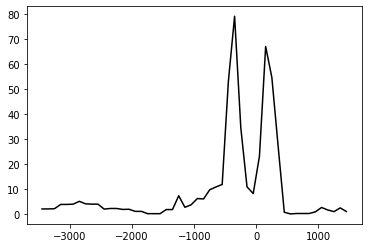

In [31]:
plt.plot([np.mean(timeblock) for timeblock in AOR_df_aoristic.keys()], AOR_df_aoristic.values(), color="black")

### Monte Carlo

Notice that the dataset has a 'FirstStartDate' and 'FirstEndDate' columns (These refer to the earliest time a mound was used, perhaps the first burial. Mounds are often reused over time)
. On the basis of the interval defined by these dates, we generate a new column of 1000  random numbers selected from the interval defined by the start date and end date, following the trapezoid distribution defined at the very top of this script. For the purpose of this script, imperfect values such as 'beginning of 4th c' are ignored and excluded from consideration.


In [33]:
AOR_df["randoms"] = AOR_df.apply(lambda row: model_date(row["FirstStartDate"], row["FirstEndDate"], size=1000, scale=100), axis=1)
Izvestia_df["randoms"] = Izvestia_df.apply(lambda row: model_date(row["FirstStartDate"], row["FirstEndDate"], size=1000, scale=100), axis=1)

In [34]:
AOR_df["FirstStartDate"].min()

-3500.0

In [35]:
AOR_df["FirstEndDate"].max()

1850.0

Adela comments: the bit where get_number is used below is unclear to me. Are we grabbing each number from the randoms and placing it on the timeline by the century it falls into? The result being a histogram of how many times a century is represented within dataset, but this time based on 1000 * moundcount. We may be losing the SD that a true MC model (iterative generation of 1000 numbers over and over again) would generate, but maybe that can be tested later/

Vojtech's reply to Adela: `get_number()` is a way how to retrieve a simulation variant; the 1000 random numbers for each mound  are already there in the "randoms" columnm. Now the task is to use these numbers in a meaningful way. I am still not sure how to implement SD here, since here I just plot each simulation variant one by one, without further inspection what is there in each individual time block.

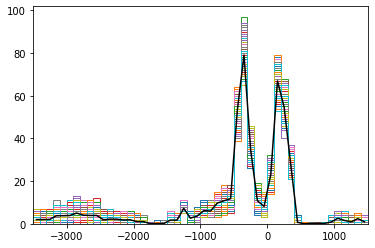

In [36]:
step = 100
bin_ranges=[n for n in range(-3500, 1500 + step, step)]
for n in range(len(AOR_df.iloc[0]["randoms"])): # for each number in length of our random numbers
  dates_variant = AOR_df.apply(lambda row: get_number(row, n), axis=1)
  plt.hist(dates_variant, bins=bin_ranges, histtype='step', stacked=True, fill=False)
  plt.xlim(-3500, 1500)

plt.plot([np.mean(timeblock) for timeblock in AOR_df_aoristic.keys()], AOR_df_aoristic.values(), color="black")

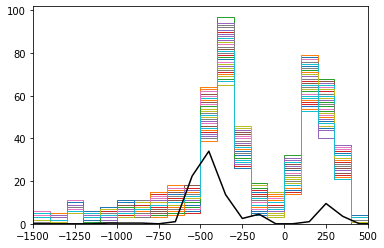

In [49]:
step = 100
bin_ranges=[n for n in range(-3500, 1500 + step, step)]
for n in range(len(AOR_df.iloc[0]["randoms"])): # for each number in lenght of our random numbers
  dates_variant = AOR_df.apply(lambda row: get_number(row, n), axis=1)
  plt.hist(dates_variant, bins=bin_ranges, histtype='step', stacked=True, fill=False)
  plt.xlim(-1500, 500)

plt.plot([np.mean(timeblock) for timeblock in Izvestia_df_aoristic.keys()], Izvestia_df_aoristic.values(), color="black")

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/kasev/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

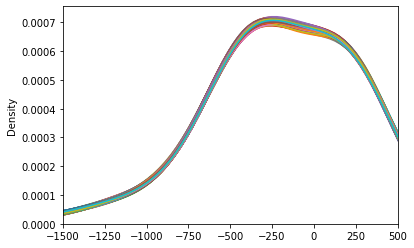

In [48]:
bin_ranges=[n for n in range(-1500, 500 + step, step)]
for n in range(len(AOR_df.iloc[0]["randoms"])): # for each number in length of our random numbers
  dates_variant = AOR_df.apply(lambda row: get_number(row, n), axis=1)
  sns.distplot(dates_variant, hist=False)
  plt.xlim(-1500, 500)

In [ ]:
for n in range(len(AOR_df.iloc[0]["randoms"])): # for each number in length of our random numbers
    dates_variant = AOR_df.apply(lambda row: get_number(row, n), axis=1)


In [ ]:
def plot_timeblocks_data(list_of_timeblocks_data, ax=None, color=None):
  """
  plot timeblocks data as a series of overlapping line plots 
  """
  for timeblocks in list_of_timeblocks_data:
    x = [np.mean(tuptup[0]) for tuptup in timeblocks]
    y = [tuptup[1] for tuptup in timeblocks]
    if ax != None:
        if color != None:
            ax.plot(x, y, color=color)
        else: 
            ax.plot(x, y)
    else:
        if color != None:
            plt.plot(x, y, color=color)
        else: 
            plt.plot(x, y)

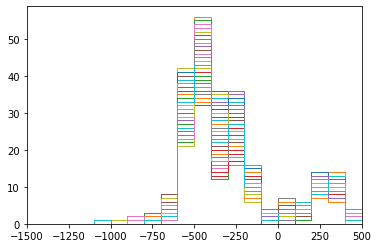

In [92]:
bin_ranges=[n for n in range(-1500, 500 + step, step)]
for n in range(len(Izvestia_df.iloc[0]["randoms"])): # for each number in lenght of our random numbers
  dates_variant = Izvestia_df.apply(lambda row: get_number(row, n), axis=1)
  plt.hist(dates_variant, bins=bin_ranges, histtype='step', stacked=True, fill=False)
  plt.xlim(-1500, 500)

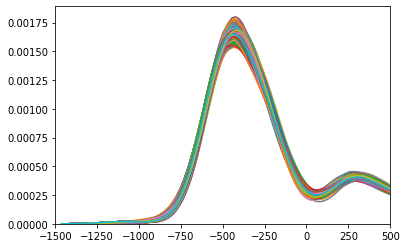

In [93]:
bin_ranges=[n for n in range(-1500, 500 + step, step)]
for n in range(len(Izvestia_df.iloc[0]["randoms"])): # for each number in lenght of our random numbers
  dates_variant = Izvestia_df.apply(lambda row: get_number(row, n), axis=1)
  sns.distplot(dates_variant, hist=False)
  plt.xlim(-1500, 500)

## b) Test with PHI

In [ ]:
# read the EDH dataset from sciencedata.dk
PHI = sddk.read_file("SDAM_data/PHI/PHI_dated_2020-06-23.json", "df", conf)

In [ ]:
cd resp.read()

In [ ]:
# in case that the dataset cell values are encasulated within lists (what often happens when the dataset is transformed by R), uncomment the last two lines
def lists_to_values(list_or_value):
  if isinstance(list_or_value, list):
    value = list_or_value[0]
  else: 
    value = list_or_value
  return value
#for column in PHI.columns:
#  PHI[column] = PHI.apply(lambda row: lists_to_values(row[column]), axis=1)

In [ ]:
PHI.head(5)

,URL,Book,Text,hdr1,hdr2,tildeinfo,note,lines,metadata,data,filename,PHI_ID,hdr1_scrape,hdr2_scrape,raw_date,dating_dict,not_before,not_after,or,date_tags,certainty,link
1,https://epigraphy.packhum.org/text/1,IG I³,1,None,None,Att. — Ath.: Akr. — stoich. 35 — c. 510-500 a....,None,12,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n,ἔδοχσεν το͂ι δέμοι· τ̣[ὸς ἐ Σ]αλαμ̣[ῖνι κλερόχ...,IG-I-3.csv,1,Regions\nAttica (IG I-III)Attica,IG I³\n1,c. 510-500 a.,"{'or': None, 'not_before': -511, 'not_after': ...",-511.0,-499.0,None,"[range, phase, ca]",None,None
2,https://epigraphy.packhum.org/text/2,IG I³,2,None,None,Att. — non-stoich. — c. 500 a.,None,14,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n\n,[․․8-9․․․]ν̣ βολ — — — — — — — — — —\n[․6-7․․]...,IG-I-3.csv,2,Regions\nAttica (IG I-III)Attica,IG I³\n2,c. 500 a.,"{'or': None, 'not_before': -505, 'not_after': ...",-505.0,-495.0,None,"[exact, phase, ca]",None,None
3,https://epigraphy.packhum.org/text/3,IG I³,3,None,None,Att. — stoich. 21 — 490-480 a.,None,13,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n,[․]αρ[․․․․]ι ℎερακλειο[․․5․․]\n[․]αρ̣ο#⁷[․] τι...,IG-I-3.csv,3,Regions\nAttica (IG I-III)Attica,IG I³\n3,490-480 a.,"{'or': None, 'not_before': -490, 'not_after': ...",-490.0,-480.0,None,[range],None,None
4,https://epigraphy.packhum.org/text/4,IG I³,4,None,None,Att. — stoich. 38 — 485/4 a.,None,58,\nface A.1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n\n\...,[․․․․․․․․․․․․․․․․․․38․․․․․․․․․․․․․․․․․․]\n[․․․...,IG-I-3.csv,4,Regions\nAttica (IG I-III)Attica,IG I³\n4,485/4 a.,"{'or': None, 'not_before': -485, 'not_after': ...",-485.0,-484.0,None,[range],None,None
5,https://epigraphy.packhum.org/text/5,IG I³,5,None,None,Att. — c. 500 a.\n\nSee also:\nI.Eleusis 13,None,6,\n1\n\n\n\n \n5\n\n,[ἔδοχσε]ν [⋮ τε͂ι βολε͂ι] ⋮ καὶ [τ]ο͂ι δέμοι ⋮...,IG-I-3.csv,5,Regions\nAttica (IG I-III)Attica,IG I³\n5,c. 500 a.,"{'or': None, 'not_before': -505, 'not_after': ...",-505.0,-495.0,None,"[exact, phase, ca]",None,None


In [ ]:
PHI["not_after"] = pd.to_numeric(PHI["not_after"])
PHI["not_before"] = pd.to_numeric(PHI["not_before"])

In [ ]:
len(PHI)

216702

In [ ]:
### how many of the inscriptions have at least one date
PHI_dated = PHI[(PHI["not_before"].notnull()) | (PHI["not_after"].notnull())]
len(PHI_dated)

130946

In [ ]:
%%time
PHI_dated["randoms"] = PHI_dated.apply(lambda row: model_date(row["not_before"], row["not_after"], size=100), axis=1)

CPU times: user 1min 23s, sys: 685 ms, total: 1min 23s
Wall time: 1min 23s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
PHI_dated[(PHI_dated["not_before"] > -10) & (PHI_dated["not_after"] < 10)]

,URL,Book,Text,hdr1,hdr2,tildeinfo,note,lines,metadata,data,filename,PHI_ID,hdr1_scrape,hdr2_scrape,raw_date,dating_dict,not_before,not_after,or,date_tags,certainty,link,randoms
5440,/text/5440?location=1365&patt=&bookid=5&offset...,IG II²,3175,Regions\nAttica (IG I-III)\nAttica,IG II²\n3175,Att. — 10/9-2/3,None,5,1\n\n\n\n5,ὁ δῆμος ἀπὸ τῶν δοθεισῶν δωρεῶν ὑπὸ Γαίου Ἰουλ...,IG-II-2.csv,5440,None,None,10/9-2/3,"{'or': None, 'not_before': 10, 'not_after': 3,...",10.0,3.0,None,[range],None,None,"[12, 14, 13, 13, 16, 13, 15, 16, 12, 12, 15, 1..."
5518,/text/5518?location=1365&patt=&bookid=5&offset...,IG II²,3250,Regions\nAttica (IG I-III)\nAttica,IG II²\n3250,Att. — 2 p.,None,2,1\n,ὁ δῆμος\nΓάιον Καίσαρα Σεβαστοῦ υἱὸν νέον Ἄρη.,IG-II-2.csv,5518,None,None,2 p.,"{'or': None, 'not_before': 2, 'not_after': 2, ...",2.0,2.0,None,[exact],None,None,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
5522,/text/5522?location=1365&patt=&bookid=5&offset...,IG II²,3253,Regions\nAttica (IG I-III)\nAttica,IG II²\n3253,Att. — 4 p.,None,2,1\n,ὁ δῆμος\nΣεβαστὸν Καίσαρα.,IG-II-2.csv,5522,None,None,4 p.,"{'or': None, 'not_before': 4, 'not_after': 4, ...",4.0,4.0,None,[exact],None,None,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
5523,/text/5523?location=1365&patt=&bookid=5&offset...,IG II²,3254,Regions\nAttica (IG I-III)\nAttica,IG II²\n3254,Att. — 4 p.,None,2,1\n,ὁ δῆμος\nΤιβέριον Καίσαρα.,IG-II-2.csv,5523,None,None,4 p.,"{'or': None, 'not_before': 4, 'not_after': 4, ...",4.0,4.0,None,[exact],None,None,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
5524,/text/5524?location=1365&patt=&bookid=5&offset...,IG II²,3255,Regions\nAttica (IG I-III)\nAttica,IG II²\n3255,Att. — 4 p.,None,2,1\n,ὁ δῆμος\nΓερμανικὸν Καίσαρα.,IG-II-2.csv,5524,None,None,4 p.,"{'or': None, 'not_before': 4, 'not_after': 4, ...",4.0,4.0,None,[exact],None,None,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350128,/text/350128?location=1403&patt=&bookid=879&of...,"IG XII,4",2:558,"Regions\nAegean Islands, incl. Crete (IG XI-[X...","IG XII,4\n2:558",Kos Isl. — Kos — 9 AD — ClRh 9 (1938) 137-148 ...,Dedication in Nabataean and Greek to Aphrodite...,14,"I.1\n\n\n\n5\nII.6\n\n\n\nI, transl.1\n\n\n\n5",[bjrḥ ․․] šnt 18 lḥr[tt]\n[mlk nbṭ]w | ῾bd ...,IG-XII-4.csv,350128,None,None,9 AD,"{'or': None, 'not_before': 9, 'not_after': 9, ...",9.0,9.0,None,[exact],None,None,"[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
350209,/text/350209?location=1403&patt=&bookid=879&of...,"IG XII,4",2:637,"Regions\nAegean Islands, incl. Crete (IG XI-[X...","IG XII,4\n2:637",Kos Isl. — Halasarna (Kardamaina) — 1-4 AD — R...,Dedication of a shrine to C. Caesar. Base of ...,5,1\n\n\n\n5,ὁ δᾶμος\nὁ Ἁλασαρνιτᾶν\nΓαΐωι Ἰουλίωι θεοῦ Σεβ...,IG-XII-4.csv,350209,None,None,1-4 AD,"{'or': None, 'not_before': 1, 'not_after': 4, ...",1.0,4.0,None,[range],None,None,"[2, 3, 4, 2, 1, 3, 3, 2, 2, 3, 3, 3, 4, 3, 2, ..."
350438,/text/350438?location=1403&patt=&bookid=879&of...,"IG XII,4",2:866,"Regions\nAegean Islands, incl. Crete (IG XI-[X...","IG XII,4\n2:866","Kos Isl. — Kos — Asklepieion — 2nd c. BC (I), ...",None,9,I.1\n\nII.1\n\n\n\n\nI.5\n,〚[ὁ δᾶμος] ἐ̣τ̣[ί]μ̣[α]σ̣ε̣〛\n\nΑὖλον Δίδιον Π...,IG-XII-4.csv,350438,None,None,"2nd c. BC (I), late 1st c. BC (II)","{'or': None, 'not_before': -2, 'not_after': -2...",-2.0,-2.0,None,[exact],None,None,"[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -..."
350598,/text/350598?location=1403&patt=&bookid=879&of...,"IG XII,4",2:1024,"Regions\nAegean Islands, incl. Crete (IG XI-[X...","IG XII,4\n2:1024","Kos Isl. — Kos — bef. 4 AD — M. Segre, Iscr. d...",Honorific inscription for C. Caesar. Base of ...,4,1\n\n\n,[ἁ βουλ]ὰ Γάϊον\n[Καίσαρ]α Σεβαστοῦ\n[Καίσαρ]ο...,IG-XII-4.csv,350598,None,None,bef. 4 AD,"{'or': None, 'not_before': 4, 'not_after': 4, ...",4.0,4.0,None,[exact],None,None,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."


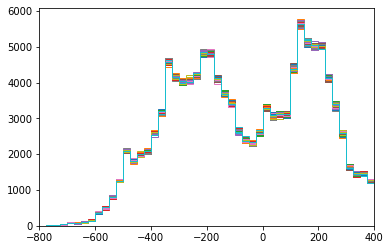

In [ ]:
def get_number(row, n):
  try:
    return row["randoms"][n]
  except:
    return None

step = 25
bin_ranges=[n for n in range(-800, 400 + step, step)]
for n in range(len(PHI_dated.iloc[0]["randoms"])): # for each number in lenght of our random numbers
  dates_variant = PHI_dated.apply(lambda row: get_number(row, n), axis=1)
  plt.hist(dates_variant, bins=bin_ranges, histtype='step', stacked=True, fill=False)
  plt.xlim(-800, 400)


(-800.0, 400.0)

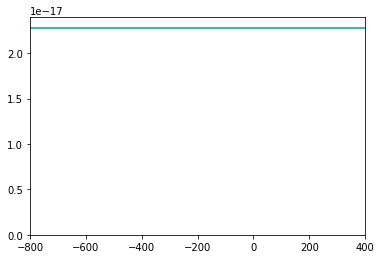

In [ ]:
for n in range(100):
  dates_variant = PHI_dated.apply(lambda row: get_number(row, n), axis=1)
  sns.distplot(dates_variant, hist=False)
plt.xlim(-800, 400)

## c) Test with EDH

In [ ]:
# read the EDH dataset from sciencedata.dk
EDH = sddk.read_file("SDAM_data/EDH/EDH_cleaned.json", "df", conf)

In [ ]:
def lists_to_values(list_or_value):
  if isinstance(list_or_value, list):
    value = list_or_value[0]
  else: 
    value = list_or_value
  return value
for column in EDH.columns:
  EDH[column] = EDH.apply(lambda row: lists_to_values(row[column]), axis=1)

In [ ]:
EDH.head(5)

,diplomatic_text,literature,trismegistos_uri,id,findspot_ancient,not_before,type_of_inscription,work_status,edh_geography_uri,not_after,country,province_label,transcription,material,height,width,findspot_modern,depth,commentary,uri,responsible_individual,last_update,language,modern_region,letter_size,type_of_monument,people,year_of_find,findspot,present_location,external_image_uris,religion,fotos,geography,military,social_economic_legal_history,coordinates,text_cleaned,origdate_text,objecttype,province_label_clean,province_label_certainty,type_of_inscription_clean,type_of_inscription_certainty,material_clean,height_cm,width_cm,depth_cm,type_of_monument_clean,type_of_monument_certainty,findspot_ancient_clean,findspot_ancient_certainty,clean_text_conservative,clean_text_interpretive_word,clean_text_interpretive_sentence
0,D M / NONIAE P F OPTATAE / ET C IVLIO ARTEMONI...,"AE 1983, 0192.; M. Annecchino, Puteoli 4/5, 19...",https://www.trismegistos.org/text/251193,HD000001,"Cumae, bei",0071,epitaph,provisional,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0130,Italy,Latium et Campania (Regio I),D(is) M(anibus) / Noniae P(ubli) f(iliae) Opta...,"Marmor, geädert / farbig",33 cm,34 cm,"Cuma, bei",2.7 cm,(C): 2. Hälfte 1. - Anfang 2. Jh. - AE; Ende ...,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2014-04-07,Latin,Campania,3.2-2 cm,tabula,"{'cognomen': 'Optata', 'person_id': '1', 'gend...",{},{},{},{},{},{},{},{},{},"40.8471577,14.0550756",Dis Manibus Noniae Publi filiae Optatae et Cai...,71 AD – 130 AD,Tafel,Latium et Campania (Regio I),Certain,epitaph,Certain,Marble,33.0,34.0,2.7,tabula,Certain,Cumae,Estimated,D M Noniae P f Optatae et C Iulio Artemoni par...,Dis Manibus Noniae Publi filiae Optatae et Cai...,Dis Manibus Noniae Publi filiae Optatae et Cai...
1,C SEXTIVS PARIS / QVI VIXIT / ANNIS LXX,"AE 1983, 0080. (A); A. Ferrua, RAL 36, 1981, 1...",https://www.trismegistos.org/text/265631,HD000002,Roma,0051,epitaph,no image,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0200,Italy,Roma,C(aius) Sextius Paris / qui vixit / annis LXX,marble: rocks - metamorphic rocks,28 cm,85 cm,Roma,{},AE 1983: Breite: 35 cm.,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2014-04-07,Latin,Lazio,4 cm,tabula,"{'age: years': '70', 'cognomen': 'Paris', 'gen...",1937,"Via Nomentana, S. Alessandro, Kirche",{},{},{},{},{},{},{},"41.895466,12.482324",Caius Sextius Paris qui vixit annis LXX ...,51 AD – 200 AD,Tafel,Roma,Certain,epitaph,Certain,Marble,28.0,85.0,NaN,tabula,Certain,Roma,Certain,C Sextius Paris qui vixit annis LXX,Caius Sextius Paris qui vixit annis LXX,Caius Sextius Paris qui vixit annis LXX
2,[ ]VMMIO [ ] / [ ]ISENNA[ ] / [ ] XV[ ] / [ ] / [,"AE 1983, 0518. (B); J. González, ZPE 52, 1983,...",https://www.trismegistos.org/text/220675,HD000003,{},0131,honorific inscription,provisional,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0170,Spain,Baetica,[P(ublio) M]ummio [P(ubli) f(ilio)] / [Gal(eri...,marble: rocks - metamorphic rocks,(37) cm,(34) cm,Tomares,(12) cm,(B): [S]isenna ist falscher Kasus; folgende E...,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2006-08-31,Latin,Sevilla,4.5-3 cm,statue base,"{'nomen': 'Mummius+', 'cognomen': 'Sisenna+ Ru...",before 1975,{},"Sevilla, Privatbesitz",{},{},{},{},{},{},"37.37281,-6.04589",Publio Mummio Publi filio Galeria Sisennae Rut...,131 AD – 170 AD,Statuenbasis,Baetica,Certain,honorific inscription,Certain,Marble,37.0,34.0,12.0,statue base,Certain,NULL,NULL,ummio isenna Xv,Publio Mummio Publi filio Galeria Sisennae Rut...,Publio Mummio Publi filio Galeria Sisennae Rut...
3,[ ]AVS[ ]LLA / M PORCI NIGRI SER / DOMINAE VEN...,"AE 1983, 0533. (B); A.U. Stylow, Gerión 1, 198...",https://www.trismegistos.org/text/222102,HD000004,Ipolcobulcula,0151,votive inscription,checked with photo,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0200,Spain,Baetica,[---?]AV(?)S(?)[---]L(?)L(?)A / M(arci) Porci ...,limestone: rocks - clastic sediments,(39) cm,27 cm,Carcabuey,18 

In [ ]:
EDH["not_after"] = pd.to_numeric(EDH["not_after"])
EDH["not_before"] = pd.to_numeric(EDH["not_before"])

In [ ]:

### how many of the inscriptions have at least one date
EDH_dated = EDH[(EDH["not_before"].notnull()) | (EDH["not_after"].notnull())]
len(EDH_dated)

57782

In [ ]:
len(EDH_dated[EDH_dated["not_after"].isnull()])

3457

In [ ]:
EDH_dated["randoms"] = EDH_dated.apply(lambda row: model_date(row["not_before"], row["not_after"]), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
EDH_condensed = EDH_dated[["id", "not_before", "not_after", "randoms"]]
EDH_condensed.head(20)

,id,not_before,not_after,randoms
0,HD000001,71.0,130.0,"[118, 113, 126, 113, 99, 99, 90, 91, 89, 124, ..."
1,HD000002,51.0,200.0,"[105, 142, 84, 65, 90, 105, 102, 165, 95, 148,..."
2,HD000003,131.0,170.0,"[157, 136, 135, 132, 151, 160, 145, 133, 146, ..."
3,HD000004,151.0,200.0,"[175, 172, 161, 164, 154, 181, 177, 165, 178, ..."
4,HD000005,1.0,200.0,"[155, 103, 182, 110, 20, 145, 180, 85, 118, 14..."
5,HD000006,71.0,150.0,"[134, 130, 142, 122, 107, 146, 80, 128, 99, 10..."
6,HD000007,-100.0,-51.0,"[-58, -91, -76, -59, -65, -61, -80, -66, -69, ..."
7,HD000008,101.0,200.0,"[154, 123, 117, 114, 162, 144, 165, 109, 161, ..."
8,HD000009,201.0,300.0,"[212, 244, 263, 288, 271, 211, 284, 276, 245, ..."
9,HD000010,101.0,200.0,"[180, 133, 156, 146, 197, 151, 126, 131, 170, ..."


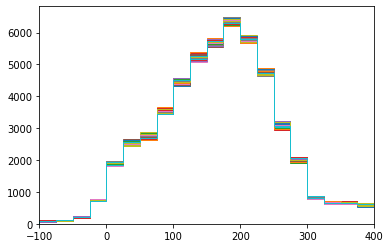

In [ ]:
step = 25
bin_ranges=[n for n in range(-100, 400 + step, step)]
for n in range(len(EDH_dated.iloc[0]["randoms"])): # for each number in lenght of our random numbers
  dates_variant = EDH_dated.apply(lambda row: get_number(row, n), axis=1)
  plt.hist(dates_variant, bins=bin_ranges, histtype='step', stacked=True, fill=False)
  plt.xlim(-100, 400)


(-100.0, 400.0)

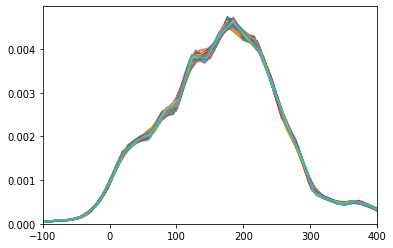

In [ ]:
for n in range(100):
  dates_variant = EDH_condensed.apply(lambda row: get_number(row, n), axis=1)
  sns.distplot(dates_variant, hist=False)
plt.xlim(-100, 400)